# Data Exploration

Once we get a new dataset, our first steps is to start some data exploration. In this step, we are trying to assess things like:

* The quality of the data
* How various variables are distributed
* Checking for outliers
* Correlations between variables
* Separability (can you tell your data is different when your target variable changes?)


References
Data source: https://www.kaggle.com/wordsforthewise/lending-club

Kernel source:
https://www.kaggle.com/pileatedperch/predicting-charge-off-from-initial-listing-data
https://www.kaggle.com/sishihara/simple-lightgbm-kfold

In [48]:
import pathlib
import importlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from typing import List, Tuple
from scipy import stats
import dexplot as dxp
import scipy.stats as ss

In [49]:
DATA_PATH = pathlib.Path('./data')
RESULTS_PATH = pathlib.Path('./results')

In [50]:
df = pd.read_csv(DATA_PATH / 'accepted_2007_to_2018Q4.csv')

The command above loads our data into a DataFrame, which is an object in the pandas library.

This object has a series of methods that can help us with some preliminary exploration.

Before we start, we are going to restrict the number of variables to keep the problem simple. There is also a practical motivation:

# Variables at loan application time
Because the dataset is a historical snapshot, not all variables in the data are available to LC at the time a loan application is being evaluated. For example, the variable total_pymnt measures the payments received to date for the total amount funded for a given loan. The value for this comes long after the lifecycle of a loan is completed (where it ends at either being 'Fully Paid' or 'Charged Off'). As such, at the time a loan application is being evaluated, information from this feature is unavailable.

To get the list of variables available at loan application time, I borrow the list of variables to keep from work undertaken in this Kaggle notebook

https://www.kaggle.com/pileatedperch/predicting-charge-off-from-initial-listing-data

In [51]:
keep_list = ['addr_state', 'annual_inc', 'application_type', 
             'dti', 'earliest_cr_line', 'emp_length', 
             'emp_title', 'fico_range_high', 'fico_range_low', 
             'grade', 'home_ownership', 'id', 'initial_list_status', 
             'installment', 'int_rate', 'issue_d', 'loan_amnt', 
             'mort_acc', 'open_acc', 'pub_rec', 'pub_rec_bankruptcies', 
             'purpose', 'revol_bal', 'revol_util', 'sub_grade', 'term', 
             'title', 'total_acc', 'verification_status', 'zip_code', 'loan_status']
keep_list.sort()
df = df[keep_list]

In [52]:
df.head()

,addr_state,annual_inc,application_type,dti,earliest_cr_line,emp_length,emp_title,fico_range_high,fico_range_low,grade,...,pub_rec_bankruptcies,purpose,revol_bal,revol_util,sub_grade,term,title,total_acc,verification_status,zip_code
0,PA,55000.0,Individual,5.91,Aug-2003,10+ years,leadman,679.0,675.0,C,...,0.0,debt_consolidation,2765.0,29.7,C4,36 months,Debt consolidation,13.0,Not Verified,190xx
1,SD,65000.0,Individual,16.06,Dec-1999,10+ years,Engineer,719.0,715.0,C,...,0.0,small_business,21470.0,19.2,C1,36 months,Business,38.0,Not Verified,577xx
2,IL,63000.0,Joint App,10.78,Aug-2000,10+ years,truck driver,699.0,695.0,B,...,0.0,home_improvement,7869.0,56.2,B4,60 months,NaN,18.0,Not Verified,605xx
3,NJ,110000.0,Individual,17.06,Sep-2008,10+ years,Information Systems Officer,789.0,785.0,C,...,0.0,debt_consolidation,7802.0,11.6,C5,60 months,Debt consolidation,17.0,Source Verified,076xx
4,PA,104433.0,Individual,25.37,Jun-1998,3 years,Contract Specialist,699.0,695.0,F,...,0.0,major_purchase,21929.0,64.5,F1,60 months,Major purchase,35.0,Source Verified,174xx


In [53]:
df.shape

(2260701, 31)

At this point, if this was a real use case, stakeholders would presumably tell you what variable they are interested in.
They would also hopefully provide some dictionary explaining what each column represents.

Let's assume that we've been told that our main variable is 'loan_status'.

In [54]:
df['loan_status'].value_counts()

Fully Paid                                             1076751
Current                                                 878317
Charged Off                                             268559
Late (31-120 days)                                       21467
In Grace Period                                           8436
Late (16-30 days)                                         4349
Does not meet the credit policy. Status:Fully Paid        1988
Does not meet the credit policy. Status:Charged Off        761
Default                                                     40
Name: loan_status, dtype: int64

We are interested in examples of loans that either have been paid or that defaulted.
These are labeled:
* Fully Paid
* Charged Off

Let's keep only the rows associated with those labels

In [55]:
df = df[df['loan_status'].isin(['Fully Paid', 'Charged Off'])]

The above is going to be our target variable, but let's convert it to numerical labels

In [56]:
df['target'] = 1
df['target'] = (df['target'].where(df['loan_status'] == 'Charged Off', 0))
df = df.drop('loan_status', axis=1)

In [57]:
df.shape

(1345310, 31)

Text(0.95, 0.1, '0.2')

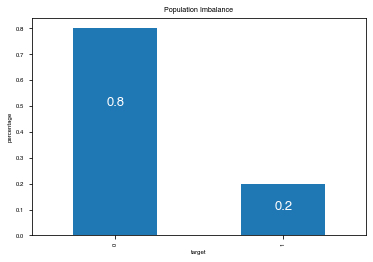

In [58]:
plt.rcParams.update({'font.size': 16})
(df['target'].value_counts()/df['target'].count()).plot(kind='bar')
plt.xlabel("target")
plt.ylabel("percentage")
plt.title("Population Imbalance")
class0_ratio = round(df[df['target']==0]['target'].count()/df['target'].count(), 2)
class1_ratio = round(df[df['target']==1]['target'].count()/df['target'].count(), 2)
plt.annotate(class0_ratio, (-0.05, 0.5), color='white', fontsize=13)
plt.annotate(class1_ratio, (0.95, 0.1), color='white', fontsize=13)

# Checking for missing values

Let's now assess the quality of our data by checking if the columns have missing values

In [59]:
df.describe()

,annual_inc,dti,fico_range_high,fico_range_low,installment,int_rate,loan_amnt,mort_acc,open_acc,pub_rec,pub_rec_bankruptcies,revol_bal,revol_util,total_acc,target
count,1.345310e+06,1.344936e+06,1.345310e+06,1.345310e+06,1.345310e+06,1.345310e+06,1.345310e+06,1.298029e+06,1.345310e+06,1.345310e+06,1.344613e+06,1.345310e+06,1.344453e+06,1.345310e+06,1.345310e+06
mean,7.624764e+04,1.828267e+01,7.001852e+02,6.961850e+02,4.380755e+02,1.323962e+01,1.441997e+04,1.670783e+00,1.159352e+01,2.152760e-01,1.344439e-01,1.624811e+04,5.181002e+01,2.498084e+01,1.996261e-01
std,6.992510e+04,1.116045e+01,3.185316e+01,3.185251e+01,2.615126e+02,4.768716e+00,8.717051e+03,2.000444e+00,5.473789e+00,6.018647e-01,3.779285e-01,2.232817e+04,2.452107e+01,1.199847e+01,3.997195e-01
min,0.000000e+00,-1.000000e+00,6.290000e+02,6.250000e+02,4.930000e+00,5.310000e+00,5.000000e+02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.000000e+00,0.000000e+00
25%,4.578000e+04,1.179000e+01,6.740000e+02,6.700000e+02,2.484800e+02,9.750000e+00,8.000000e+03,0.000000e+00,8.000000e+00,0.000000e+00,0.000000e+00,5.943000e+03,3.340000e+01,1.600000e+01,0.000000e+00
50%,6.500000e+04,1.761000e+01,6.940000e+02,6.900000e+02,3.754300e+02,1.274000e+01,1.200000e+04,1.000000e+00,1.100000e+01,0.000000e+00,0.000000e+00,1.113400e+04,5.220000e+01,2.300000e+01,0.000000e+00
75%,9.000000e+04,2.406000e+01,7.140000e+02,7.100000e+02,5.807300e+02,1.599000e+01,2.000000e+04,3.000000e+00,1.400000e+01,0.000000e+00,0.000000e+00,1.975575e+04,7.070000e+01,3.200000e+01,0.000000e+00
max,1.099920e+07,9.990000e+02,8.500000e+02,8.450000e+02,1.719830e+03,3.099000e+01,4.000000e+04,5.100000e+01,9.000000e+01,8.600000e+01,1.200000e+01,2.904836e+06,8.923000e+02,1.760000e+02,1.000000e+00


It seems like we have some missing values for *mort_acc* and for dti, based on the count

In [60]:
print("Missing Percentage")
for col in df.columns:
    print(col + " " + str(100 - 100*df[col].count()/len(df)))

Missing Percentage
addr_state 0.0
annual_inc 0.0
application_type 0.0
dti 0.027800283949417803
earliest_cr_line 0.0
emp_length 5.835903992388367
emp_title 6.376597215511666
fico_range_high 0.0
fico_range_low 0.0
grade 0.0
home_ownership 0.0
id 0.0
initial_list_status 0.0
installment 0.0
int_rate 0.0
issue_d 0.0
loan_amnt 0.0
mort_acc 3.5145059503014124
open_acc 0.0
pub_rec 0.0
pub_rec_bankruptcies 0.05180962008756751
purpose 0.0
revol_bal 0.0
revol_util 0.0637027896915896
sub_grade 0.0
term 0.0
title 1.23830195270979
total_acc 0.0
verification_status 0.0
zip_code 7.433231002096363e-05
target 0.0


Many models cannot take missing entries, so we will have to fill the missing values.
To understand how we will fill them, however, we will have to do some further data exploration.

The filling methods will be somewhat different depending on whether the column is categorical or numerical, so let's identify those now.

In [61]:
num_cols = df.select_dtypes(include=['float64', 'int64']).columns

In [62]:
df[[col for col in df.columns if col not in num_cols]]

,addr_state,application_type,earliest_cr_line,emp_length,emp_title,grade,home_ownership,id,initial_list_status,issue_d,purpose,sub_grade,term,title,verification_status,zip_code
0,PA,Individual,Aug-2003,10+ years,leadman,C,MORTGAGE,68407277,w,Dec-2015,debt_consolidation,C4,36 months,Debt consolidation,Not Verified,190xx
1,SD,Individual,Dec-1999,10+ years,Engineer,C,MORTGAGE,68355089,w,Dec-2015,small_business,C1,36 months,Business,Not Verified,577xx
2,IL,Joint App,Aug-2000,10+ years,truck driver,B,MORTGAGE,68341763,w,Dec-2015,home_improvement,B4,60 months,NaN,Not Verified,605xx
4,PA,Individual,Jun-1998,3 years,Contract Specialist,F,MORTGAGE,68476807,w,Dec-2015,major_purchase,F1,60 months,Major purchase,Source Verified,174xx
5,GA,Individual,Oct-1987,4 years,Veterinary Tecnician,C,RENT,68426831,w,Dec-2015,debt_consolidation,C3,36 months,Debt consolidation,Source Verified,300xx
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2260688,TX,Individual,Jul-2004,5 years,NaN,B,OWN,89905081,f,Oct-2016,home_improvement,B2,60 months,Home improvement,Not Verified,775xx
2260690,CA,Individual,Mar-2002,9 years,Chief Operating Officer,C,MORTGAGE,88948836,f,Oct-2016,debt_consolidation,C3,60 months,Debt consolidation,Not Verified,900xx
2260691,AZ,Individual,Jun-2011,3 years,Sales Manager,C,MORTGAGE,89996426,f,Oct-2016,home_improvement,C4,60 months,Home improvement,Source Verified,863xx
2260692,NC,Individual,Aug-1997,10+ years,Manager,C,RENT,90006534,f,Oct-2016,medical,C1,60 months,Medical expenses,Not Verified,284xx


Most of the columns above are categorical, except for earliest_cr_line and issue_id.
Those are dates. We want to transform them into appropriate date objects

In [63]:
dates_cols = ['earliest_cr_line', 'issue_d']
for c in dates_cols:
    df[c] = pd.to_datetime(df[c], format='%b-%Y')

The remaining columns should now be categorical.

In [64]:
df[df.select_dtypes('object').columns].head()

,addr_state,application_type,emp_length,emp_title,grade,home_ownership,id,initial_list_status,purpose,sub_grade,term,title,verification_status,zip_code
0,PA,Individual,10+ years,leadman,C,MORTGAGE,68407277,w,debt_consolidation,C4,36 months,Debt consolidation,Not Verified,190xx
1,SD,Individual,10+ years,Engineer,C,MORTGAGE,68355089,w,small_business,C1,36 months,Business,Not Verified,577xx
2,IL,Joint App,10+ years,truck driver,B,MORTGAGE,68341763,w,home_improvement,B4,60 months,NaN,Not Verified,605xx
4,PA,Individual,3 years,Contract Specialist,F,MORTGAGE,68476807,w,major_purchase,F1,60 months,Major purchase,Source Verified,174xx
5,GA,Individual,4 years,Veterinary Tecnician,C,RENT,68426831,w,debt_consolidation,C3,36 months,Debt consolidation,Source Verified,300xx


In [65]:
cat_cols = df.select_dtypes('object').columns

Summary for the categorical features:

In [66]:
def summarize_cats(df: pd.DataFrame, cat_cols: List[str] = []) -> pd.DataFrame:
    '''Create table summarizing categorical variables

    To display more values in Values col, set

    pd.set_option('display.max_colwidth', 100)
    '''

    df_cats = df.loc[:, cat_cols]

    print(f"Dataset Shape: {df_cats.shape}")
    summary = pd.DataFrame(df_cats.dtypes, columns=['dtypes'])
    summary = summary.reset_index()
    summary['Column Name'] = summary['index']
    summary = summary[['Column Name', 'dtypes']]
    summary['Missing'] = df_cats.isnull().sum().values
    summary['Uniques'] = df_cats.nunique().values

    for name in summary['Column Name'].value_counts().index:

        # List unique values
        list_uniques = [str(v) for v in df_cats[name].unique()]
        summary.loc[summary['Column Name'] == name,
                    'Values'] = ' | '.join(list_uniques)

        # Calculate entropy
        shares = df_cats[name].value_counts(normalize=True)
        summary.loc[summary['Column Name'] == name, 'Entropy'] = round(
            stats.entropy(shares, base=2), 2)

    return summary

In [67]:
summarize_cats(df, cat_cols)

Dataset Shape: (1345310, 14)


,Column Name,dtypes,Missing,Uniques,Values,Entropy
0,addr_state,object,0,51,PA | SD | IL | GA | MN | SC | RI | NC | CA | V...,4.83
1,application_type,object,0,2,Individual | Joint App,0.14
2,emp_length,object,78511,11,10+ years | 3 years | 4 years | 6 years | 7 ye...,3.06
3,emp_title,object,85785,378353,leadman | Engineer | truck driver | Contract S...,14.85
4,grade,object,0,7,C | B | F | A | E | D | G,2.33
5,home_ownership,object,0,6,MORTGAGE | RENT | OWN | ANY | NONE | OTHER,1.38
6,id,object,0,1345310,68407277 | 68355089 | 68341763 | 68476807 | 68...,20.36
7,initial_list_status,object,0,2,w | f,0.98
8,purpose,object,0,14,debt_consolidation | small_business | home_imp...,1.94
9,sub_grade,object,0,35,C4 | C1 | B4 | F1 | C3 | B2 | B1 | A2 | B5 | C...,4.64


With the above we have now a sense for what our categorical features look like.

Some are simply different categories, like zip_code.

However, some are ordinal, in the sense that they have a natural order. Employment length (emp length) is one example of that.


We will go back to this, but lets now move on to exploring the numerical features

# Numerical Features - Exploration

For everything that comes next, we will assume that we will deal only with the years 2013 -- 2016

In [68]:
years = [2013, 2014, 2015, 2016]
df = df[df['issue_d'].dt.year.isin(years)]

In [69]:
df.shape

(1026546, 31)

In [70]:
num_cols

Index(['annual_inc', 'dti', 'fico_range_high', 'fico_range_low', 'installment',
       'int_rate', 'loan_amnt', 'mort_acc', 'open_acc', 'pub_rec',
       'pub_rec_bankruptcies', 'revol_bal', 'revol_util', 'total_acc',
       'target'],
      dtype='object')

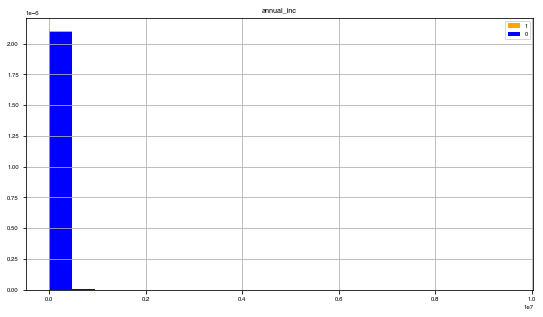

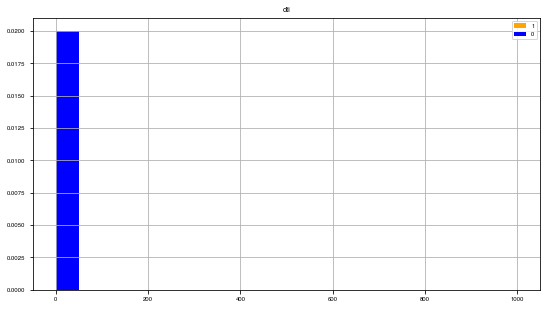

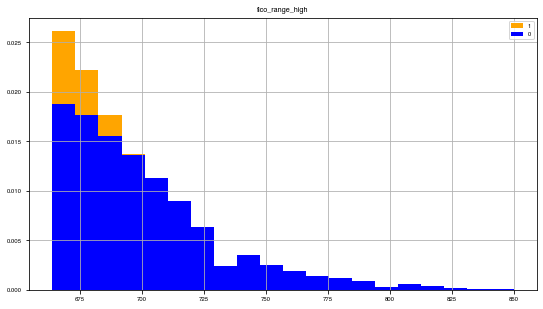

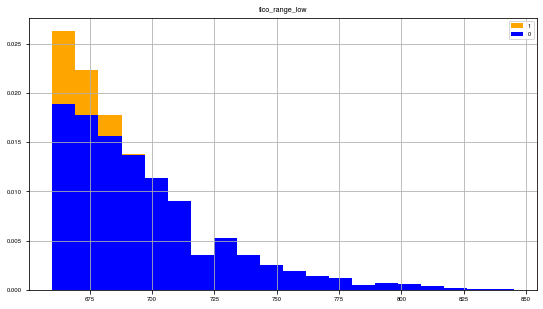

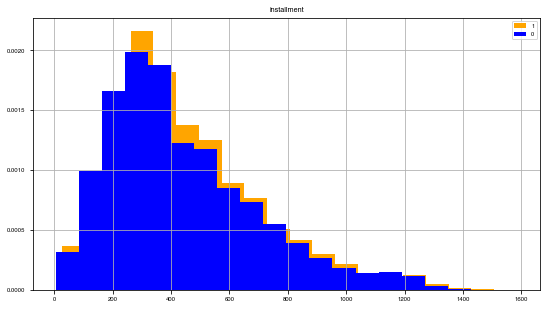

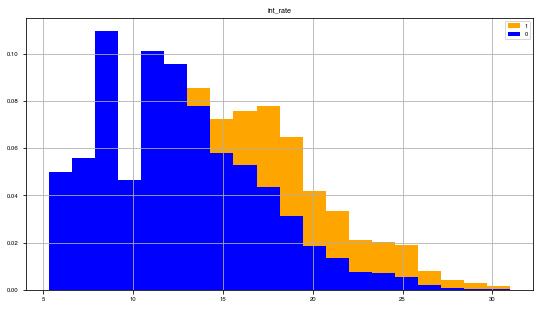

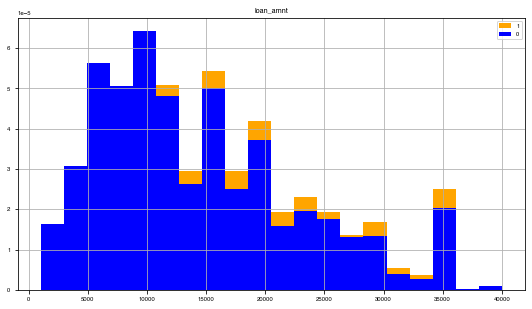

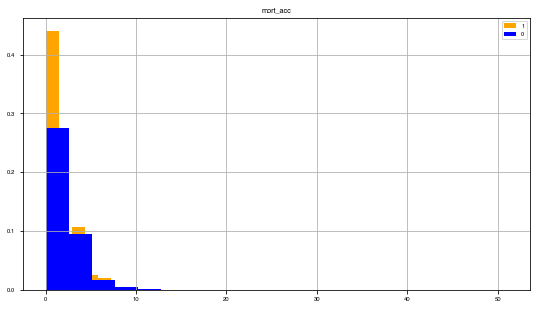

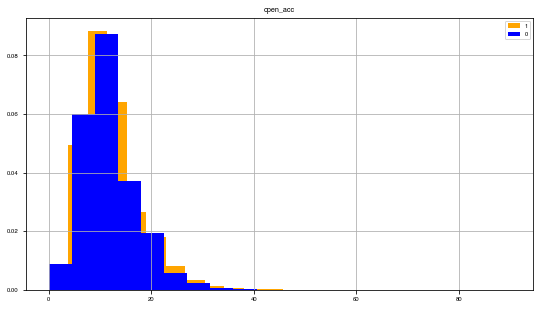

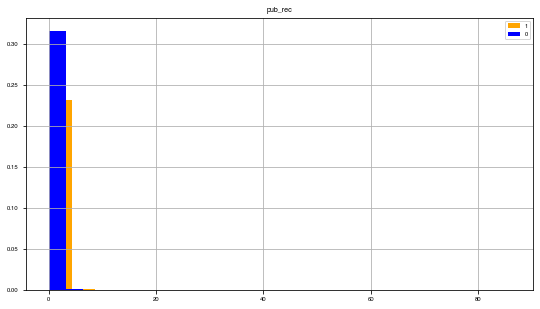

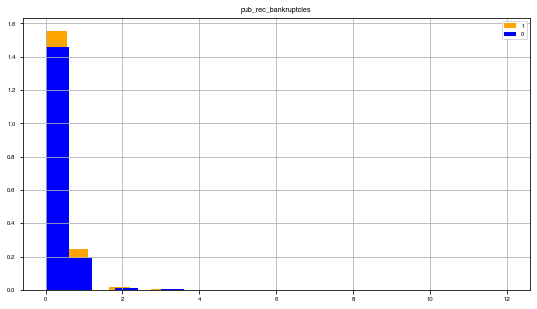

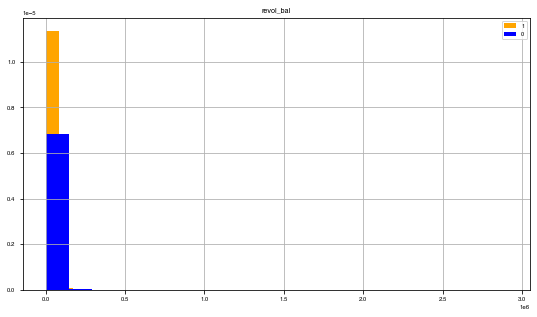

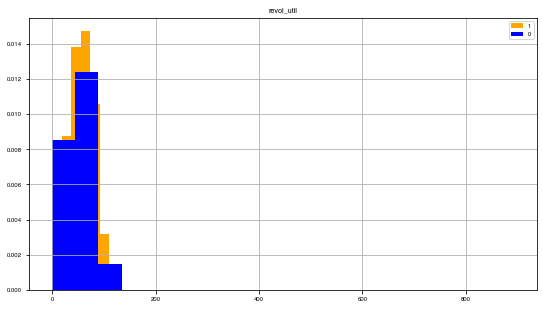

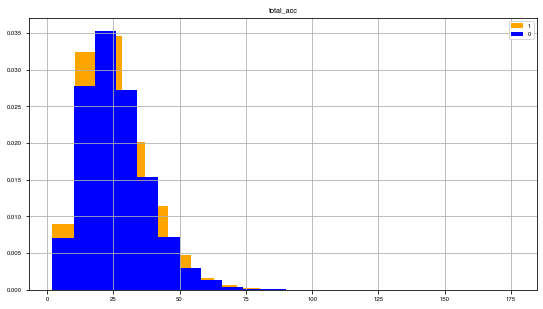

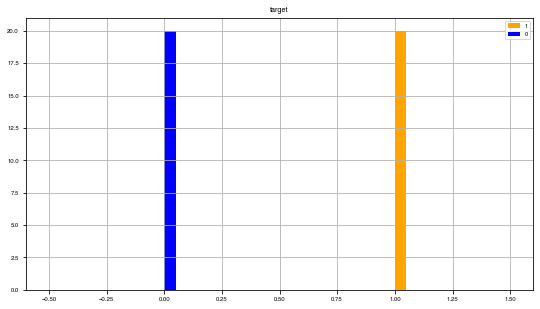

In [167]:
plt.rcParams.update({'font.size': 16})
for col in num_cols:
    plt.figure(figsize=(20,5))
    plt.subplot(1,2,1)
    df[df['target'] == 1][col].hist(label=1, color="orange", density="True", bins=20)
    df[df['target'] == 0][col].hist(label=0, color="blue", density="True", bins=20)
    plt.title(col)
    plt.legend()
 #   plt.tight_layout()
    plt.title(col)

In [159]:
plt.figure?

Signature:
plt.figure(
    num=None,
    figsize=None,
    dpi=None,
    facecolor=None,
    edgecolor=None,
    frameon=True,
    FigureClass=<class 'matplotlib.figure.Figure'>,
    clear=False,
    **kwargs,
)
Docstring:
Create a new figure, or activate an existing figure.

Parameters
----------
num : int or str, optional
    A unique identifier for the figure.

    If a figure with that identifier already exists, this figure is made
    active and returned. An integer refers to the ``Figure.number``
    attribute, a string refers to the figure label.

    If there is no figure with the identifier or *num* is not given, a new
    figure is created, made active and returned.  If *num* is an int, it
    will be used for the ``Figure.number`` attribute, otherwise, an
    auto-generated integer value is used (starting at 1 and incremented
    for each new figure). If *num* is a string, the figure label and the
    window title is set to this value.

figsize : (float, float), default: :rc

In [108]:
df.skew()

annual_inc              46.190631
dti                     11.993338
fico_range_high          1.370857
fico_range_low           1.370650
installment              0.977570
int_rate                 0.598626
loan_amnt                0.734525
mort_acc                 1.632947
open_acc                 1.293160
pub_rec                 12.142086
pub_rec_bankruptcies     3.492479
revol_bal               14.378001
revol_util              -0.043847
total_acc                0.941243
target                   1.493012
dtype: float64

Lets look at annual income in more detail. The distribution seems to be very skewed, so it may need some work

Text(0.5, 1.0, 'Annual Income')

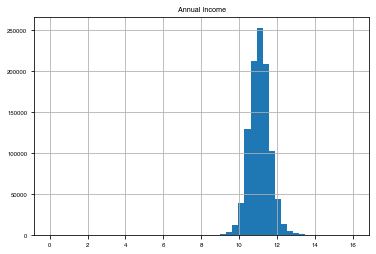

In [109]:
np.log1p(df['annual_inc']).hist(bins=50)
plt.title('Annual Income')

Text(0.5, 1.0, 'Annual Income')

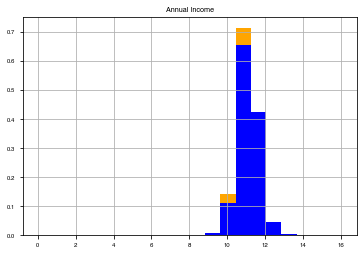

In [110]:
    np.log1p(df[df['target'] == 1]['annual_inc']).hist(label=1, color="orange", density="True", bins=20)
    np.log1p(df[df['target'] == 0]['annual_inc']).hist(label=0, color="blue", density="True", bins=20)
    plt.title("Annual Income")

In [111]:
np.log1p(df['annual_inc']).skew()

-0.12359805476385398

For a variable like Annual Income, it may be more convenient to work with a log scale. This might be true even for variables for which the skewness is not so extreme.
For example:


Text(0.5, 1.0, 'total_acc')

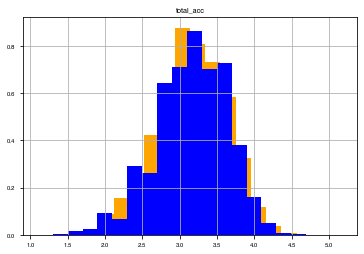

In [112]:
np.log1p(df[df['target'] == 1]['total_acc']).hist(label=1, color="orange", density="True", bins=20)
np.log1p(df[df['target'] == 0]['total_acc']).hist(label=0, color="blue", density="True", bins=20)
plt.title('total_acc')

The log transformation may cause problems if you have negative values.

For dti, we have an additional problem that the minimum value is negative, so we will have to do something about it.

In [113]:
df[num_cols].min()

annual_inc                 0.00
dti                        0.00
fico_range_high          664.00
fico_range_low           660.00
installment                4.93
int_rate                   5.32
loan_amnt               1000.00
mort_acc                   0.00
open_acc                   0.00
pub_rec                    0.00
pub_rec_bankruptcies       0.00
revol_bal                  0.00
revol_util                 0.00
total_acc                  2.00
target                     0.00
dtype: float64

In [114]:
df[df['dti']==-1]

,addr_state,annual_inc,application_type,dti,earliest_cr_line,emp_length,emp_title,fico_range_high,fico_range_low,grade,...,purpose,revol_bal,revol_util,sub_grade,term,title,total_acc,verification_status,zip_code,target


Since this is a single case, we will make this dti 0

In [115]:
df['dti'] = df['dti'].apply(lambda x: 0 if x == -1 else x)

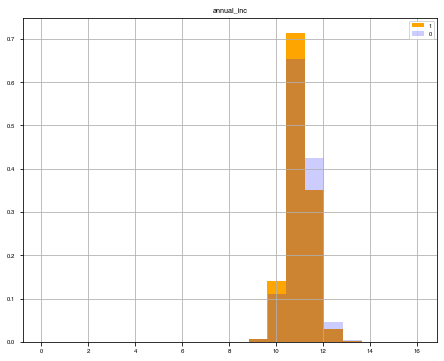

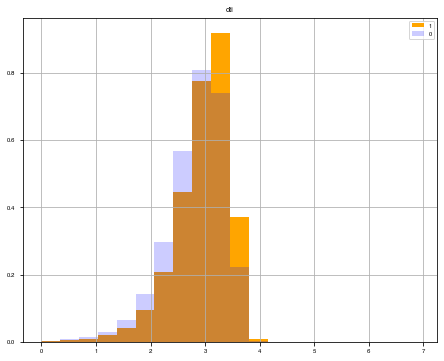

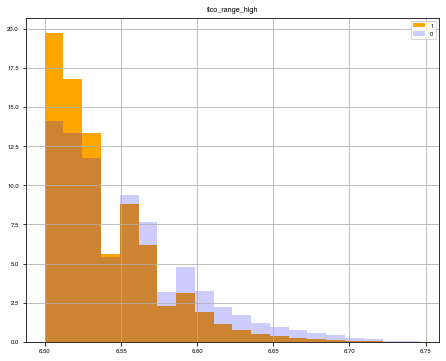

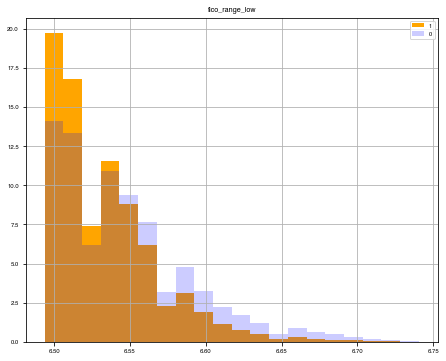

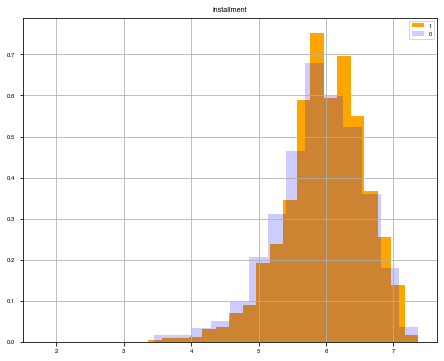

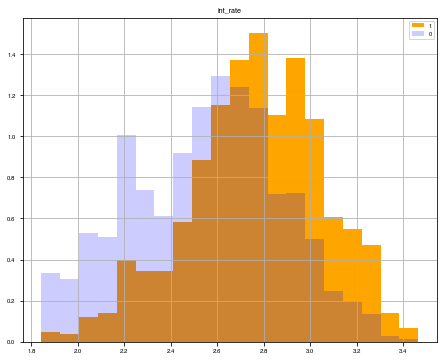

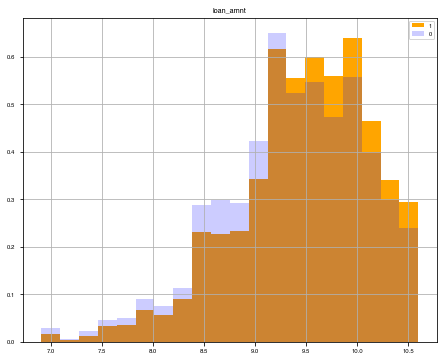

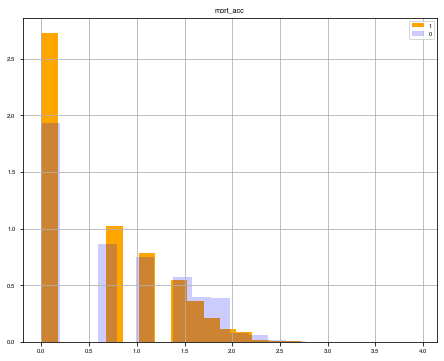

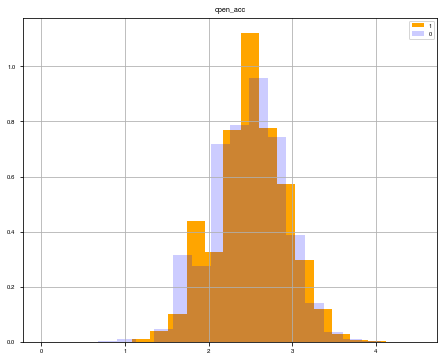

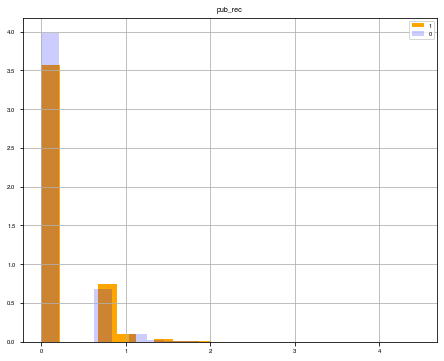

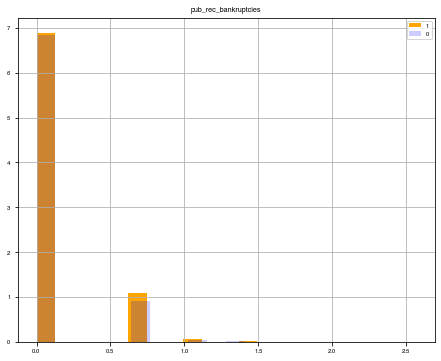

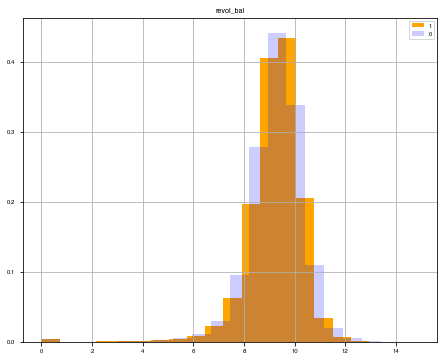

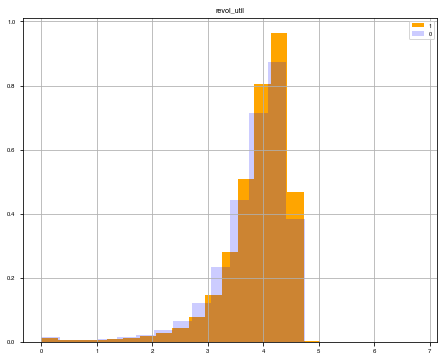

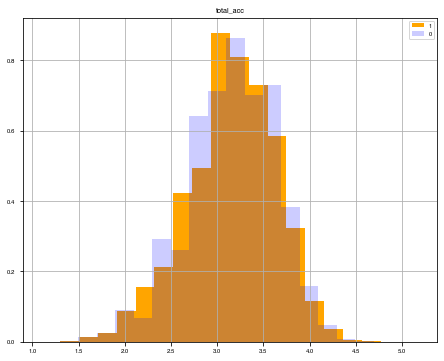

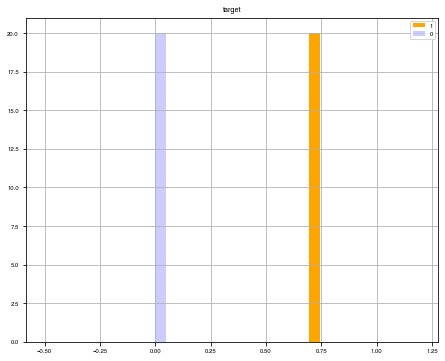

In [116]:
for col in num_cols:
    plt.figure(figsize=(12,5))
    plt.subplot(1,2,1)
    np.log1p(df[df['target'] == 1][col]).hist(label=1, color="orange", density="True", bins=20)
    np.log1p(df[df['target'] == 0][col]).hist(label=0, color="blue", density="True", bins=20, alpha=0.2)
    plt.title(col)
    plt.legend()
    plt.tight_layout()
    plt.title(col)

Based on the visuals above, one can decide which variables might be appropriate to take the log during the feature engineering stage.

Here are some distributions that look more reasonable now:
* annual income
* dti
* installment
* int_rate
* loan_amnt
* open_acc
* revol_bal
* revol_util
* total_acc



Another important aspect of these plots is the overlap between the distributions. 
If they overlap a lot, the variable does not have a lot of power (by itself) to differentiate between 0 and 1.

To check what variables correlate the most with the target (and among themselves), we can create a correlation matrix plot

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5]),
 [Text(0, 0.5, 'annual_inc'),
  Text(0, 1.5, 'dti'),
  Text(0, 2.5, 'fico_range_high'),
  Text(0, 3.5, 'fico_range_low'),
  Text(0, 4.5, 'installment'),
  Text(0, 5.5, 'int_rate'),
  Text(0, 6.5, 'loan_amnt'),
  Text(0, 7.5, 'mort_acc'),
  Text(0, 8.5, 'open_acc'),
  Text(0, 9.5, 'pub_rec'),
  Text(0, 10.5, 'pub_rec_bankruptcies'),
  Text(0, 11.5, 'revol_bal'),
  Text(0, 12.5, 'revol_util'),
  Text(0, 13.5, 'total_acc'),
  Text(0, 14.5, 'target')])

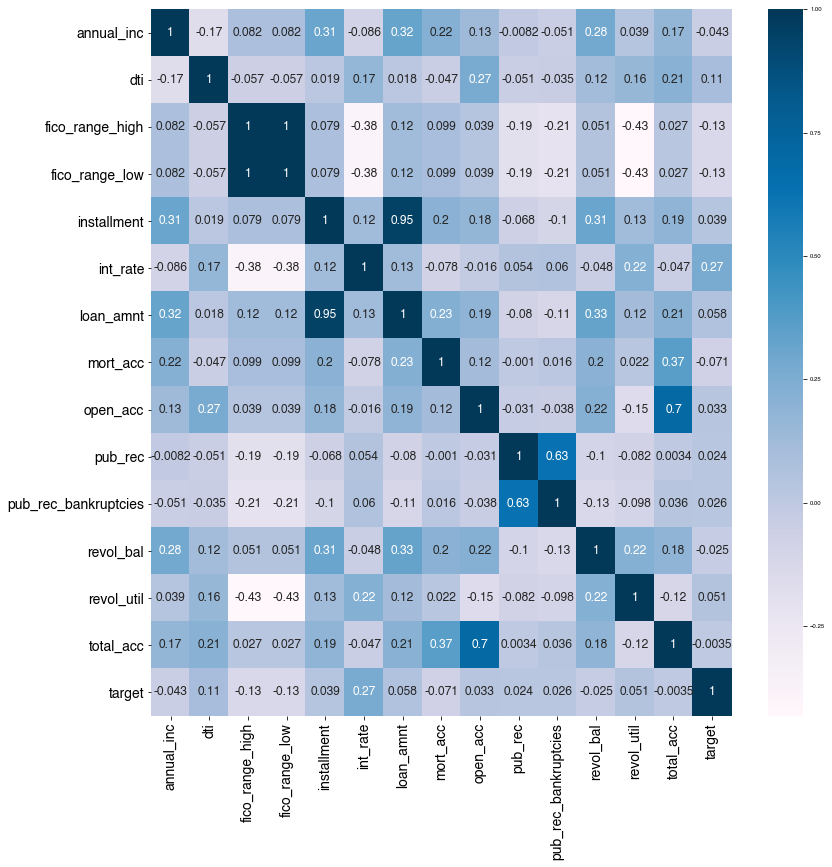

In [117]:
plt.subplots(figsize=(13,13))
sns.heatmap(df[num_cols].corr(), annot=True, cmap='PuBu', annot_kws={'size': 12})
plt.xticks(size=14)
plt.yticks(size=14)

This confirms what we saw from the previous plots: int_rate seems to be the variable with highest explanatory power.

Additionally, we see that fico_range_high and fico_range_low are *highly correlated*. We should probably drop one of those two variables.

# Categorical Features

In [118]:
cat_cols

Index(['addr_state', 'application_type', 'emp_length', 'emp_title', 'grade',
       'home_ownership', 'id', 'initial_list_status', 'purpose', 'sub_grade',
       'term', 'title', 'verification_status', 'zip_code'],
      dtype='object')

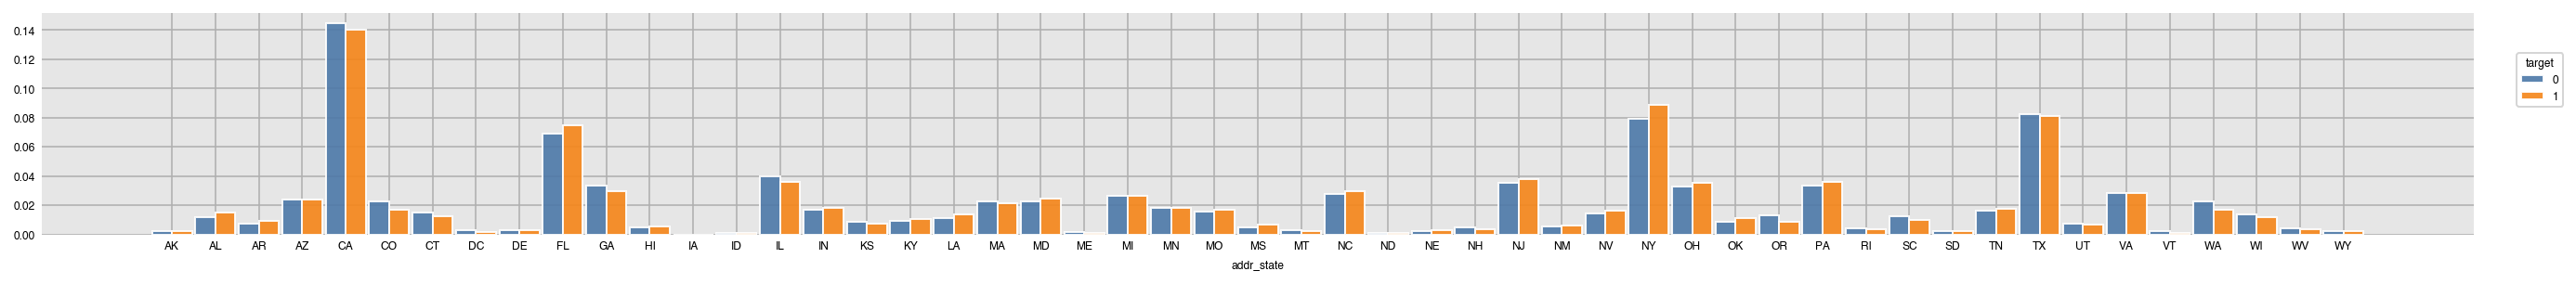

In [119]:
dxp.count('addr_state', data=df, split='target', normalize='target')

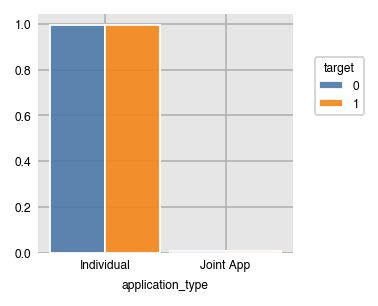

In [120]:
dxp.count('application_type', data=df, split='target', normalize='target')

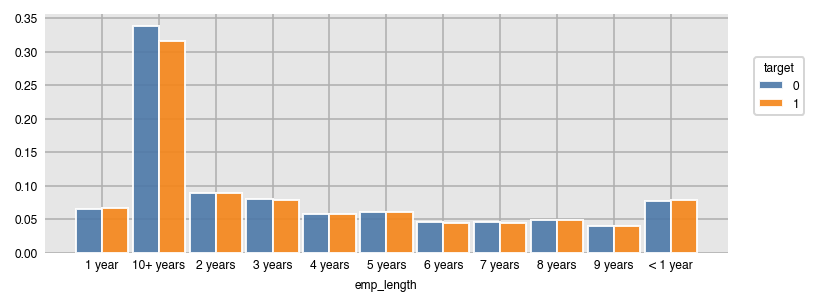

In [121]:
dxp.count('emp_length', data=df, split='target', normalize='target')

For employment title, this approach is not going to work because there are too many titles.

We call this HIGH cardinality. Let's look at some of the most common options.

In [122]:
df['emp_title'].value_counts()

Teacher                           17354
Manager                           15455
Owner                              7942
Registered Nurse                   7262
RN                                 7038
                                  ...  
Parts and Service Sales               1
Oral surgery Dental Assistant         1
Management training                   1
THCC                                  1
artesia ford sales inc                1
Name: emp_title, Length: 289540, dtype: int64

Some titles barely show up, so let's treat them separately, and see how many options we have left.

In [123]:
titles = df['emp_title'].value_counts()

In [124]:
common_titles = titles[titles>1000].index  # restricting to a subset with more than 1000 counts

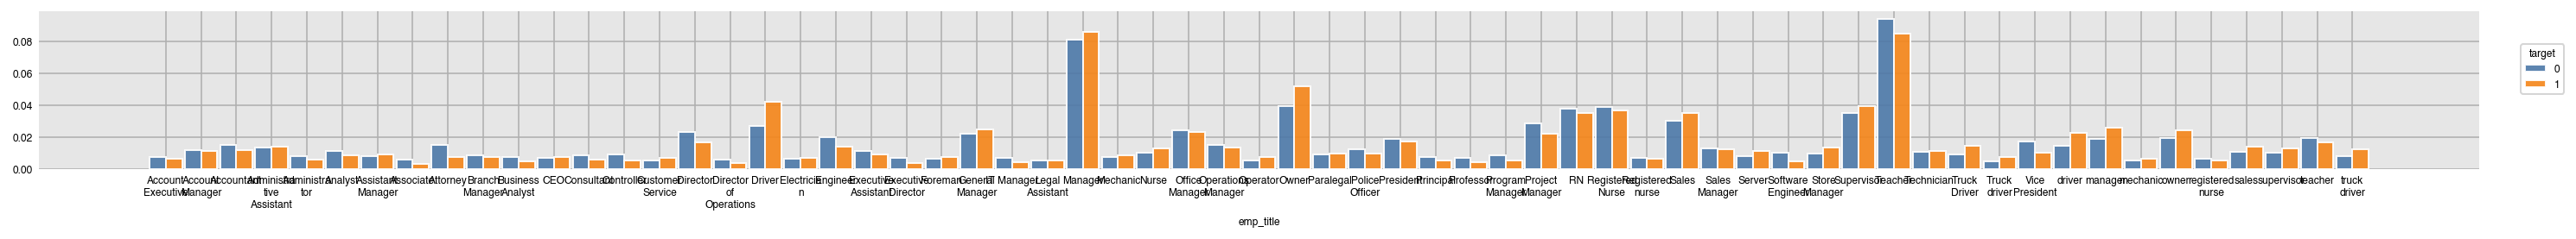

In [125]:
dxp.count('emp_title', data=df[df['emp_title'].isin(common_titles)], split='target', normalize='target', figsize=(20,2))

We see that the employment title seems to make a difference.
That said, one be must mindful before including this feature, as it can lead to some form of discriminatory bias.

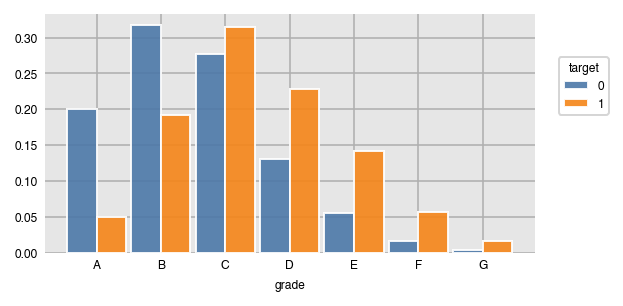

In [126]:
dxp.count('grade', data=df, split='target', normalize='target')

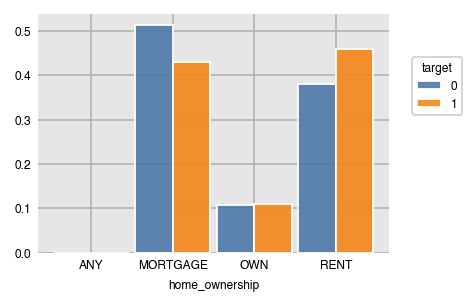

In [127]:
dxp.count('home_ownership', data=df, split='target', normalize='target')

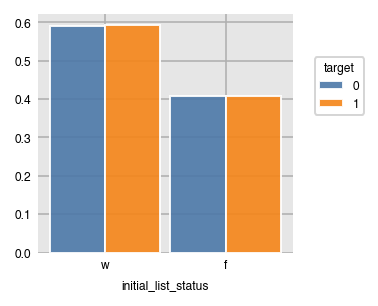

In [128]:
dxp.count("initial_list_status", data=df, split='target', normalize='target')

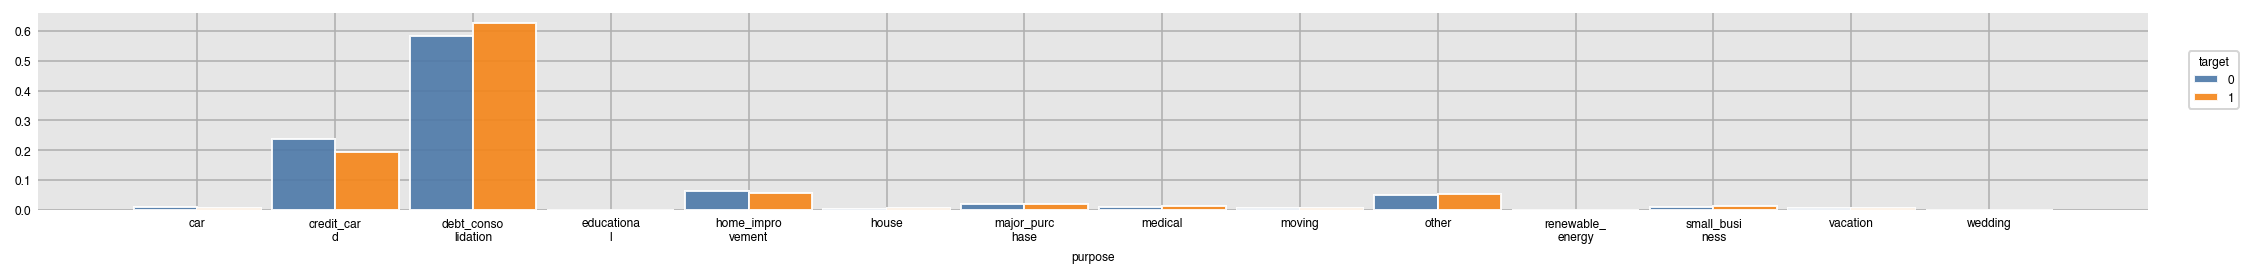

In [129]:
dxp.count("purpose", data=df, split='target', normalize='target', figsize=((15,2)))

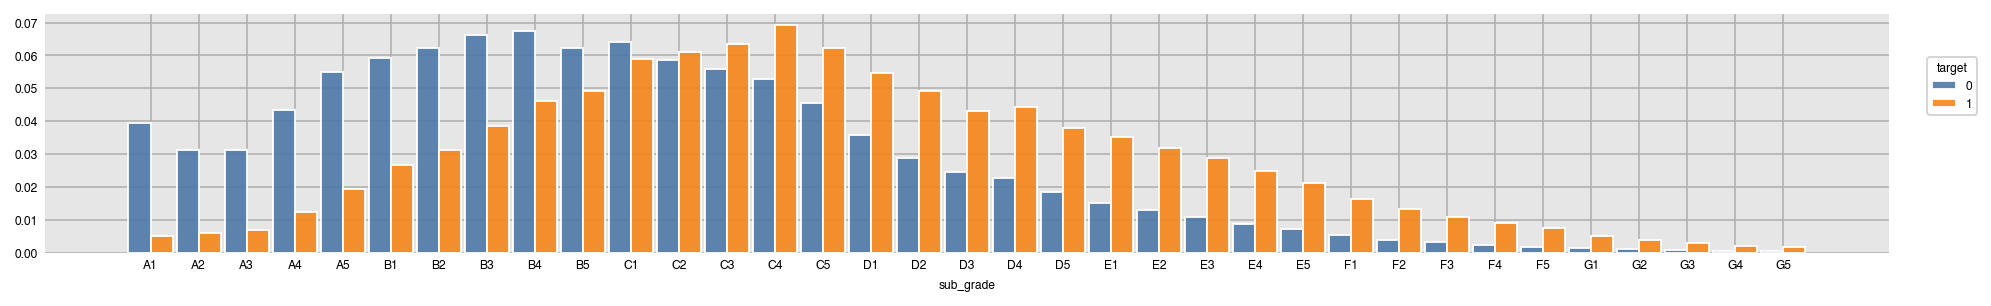

In [130]:
dxp.count("sub_grade", data=df, split='target', normalize='target')

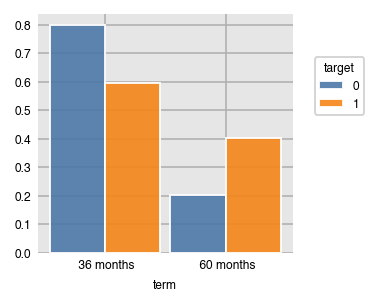

In [131]:
dxp.count("term", data=df, split='target', normalize='target')

title is another feature with high cardinality so we will ignore that one for the moment.

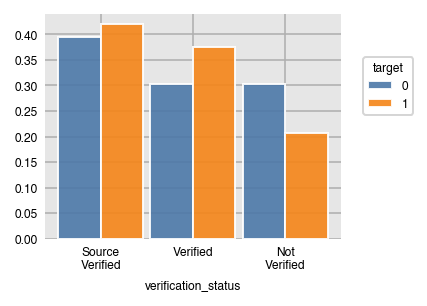

In [132]:
dxp.count("verification_status", data=df, split='target', normalize='target')

We are skipping zip_code, which also has high cardinality.

# Cramers V correlation for categorical variables

In [133]:
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [134]:
cramers_matrix = np.zeros((len(cat_cols), len(cat_cols)))

The computation above takes very long for the variable employment title due to its high cardinality
so we are going to exclude it from the computation

In [135]:
cramers_cols = list(cat_cols)
cramers_cols.append('target')

In [136]:
cramers_cols.remove('emp_title')
cramers_cols.remove('id')
cramers_cols.remove('title')

In [137]:
cramers_matrix = np.zeros((len(cramers_cols), len(cramers_cols)))

In [138]:
for i, col1 in enumerate(cramers_cols):
    for j, col2 in enumerate(cramers_cols):
        cramers_matrix[i][j] = cramers_v(df[col1], df[col2])

([<matplotlib.axis.YTick at 0x7fead7edb990>,
 [Text(0, 0.5, 'addr_state'),
  Text(0, 1.5, 'application_type'),
  Text(0, 2.5, 'emp_length'),
  Text(0, 3.5, 'grade'),
  Text(0, 4.5, 'home_ownership'),
  Text(0, 5.5, 'initial_list_status'),
  Text(0, 6.5, 'purpose'),
  Text(0, 7.5, 'sub_grade'),
  Text(0, 8.5, 'term'),
  Text(0, 9.5, 'verification_status'),
  Text(0, 10.5, 'zip_code'),
  Text(0, 11.5, 'target')])

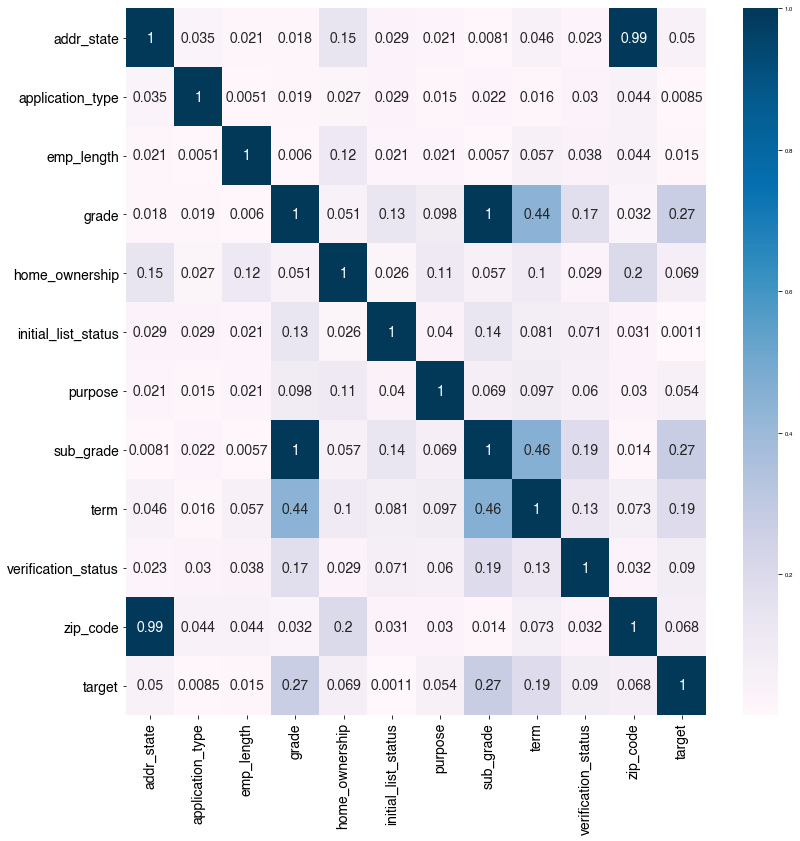

In [143]:
plt.subplots(figsize=(13,13))
plt.rcParams.update({'font.size': 15})
sns.heatmap(cramers_matrix, annot=True, cmap='PuBu', annot_kws={"size": 14})
plt.xticks(np.array(range(len(cramers_cols))) + 0.5, cramers_cols, size=14, rotation=90)
plt.yticks(np.array(range(len(cramers_cols))) + 0.5, cramers_cols, size=14, rotation=0)

The plot above reinforces our intuition: among the categorical variables, the most important ones are grade, sub_grade, term.

Notice that sub_grade and grade have a correlation of 1. This is because subgrade indirectly determines grade. We may want to keep only one of those variables at the end eventually.
A similar thing happens between addr_state and zip_code.

# Comparing training and test set

Before we get to our final conclusions, I like to compare the traning set and the test set to make sure there are no systematic deviations between each other.

In [144]:
years

[2013, 2014, 2015, 2016]

In [145]:
train_years = years[0:3]
test_years = years[3:]

In [146]:
train_years

[2013, 2014, 2015]

In [147]:
train_df = df[df['issue_d'].dt.year.isin(train_years)]

In [149]:
test_df = df[df['issue_d'].dt.year.isin(test_years)]

# Conclusions

Some conclusions:

* Among the numerical variables, *interest rate* seems to have the highest predictive power
* Among categorical variables, some important features are: *grade*, *sub_grade*, *term*
* fico_range_low and fico_range_high are correlated, so we should drop one of them
* loan_amnt and installment are also very correlated, so one should at least consider if we should keep both
* grade and subgrade might be somewhat redundant, as subgrade indirectly tells us the grade (reflected in a Cramers V correlation of 1)

* We may want to take the log of a few variables: 
    * annual income
    * dti
    * installment
    * int_rate
    * loan_amnt
    * open_acc
    * revol_bal
    * revol_util
    * total_acc

* Some categorical variables have extremely high cardinality: emp_title, title, zip_code. We might ignore those features initially.



In [200]:
"verification_status" in df.columns

True

In [206]:
s = \
    df["verification_status"].apply(bool)